# Early detection of Alzheimer's disease using blood gene expression data
## Design Project
by J. Hariharan and Dr. R. Jothi

## Packages

In [1]:
import pandas as pd
import numpy as np
import GEOparse
import os
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
import csv
from sklearn.feature_selection import SelectKBest, RFE, RFECV, SelectFromModel
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score

## 1. Pre-Processing

### Parsing GSE63060 and GSE63061 dataset

In [24]:
dataset_directory = "../DataSets/"
parsed_data_file_suffix = "_parsed_data.csv"

In [30]:
gses = {}

gses["GSE63060"] = GEOparse.get_GEO(filepath="../DataSets/GSE63060_family.soft.gz")
gses["GSE63061"] = GEOparse.get_GEO(filepath="../DataSets/GSE63061_family.soft.gz")

len(gses)

02-Mar-2023 18:34:28 INFO GEOparse - Parsing ../DataSets/GSE63060_family.soft.gz: 
02-Mar-2023 18:34:28 DEBUG GEOparse - DATABASE: GeoMiame
02-Mar-2023 18:34:28 DEBUG GEOparse - SERIES: GSE63060
02-Mar-2023 18:34:28 DEBUG GEOparse - PLATFORM: GPL6947
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539080
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539081
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539082
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539083
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539084
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539085
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539086
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539087
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539088
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539089
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539090
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539091
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539092
02-Mar-2

2

In [31]:
# 1. Finding Gene symbols for the ID_REF values
# 2. Group the rows based on Gene Symbol values
# 3. replace the groups with a single row with Gene Symbol of the group and the Median of the gene expression value

for datasetName in gses:
    gse = gses[datasetName]
    gpl_lookup = []

    for gpl_name, gpl in gse.gpls.items():
        gpl_lookup = gpl.table.filter(["ID", "ILMN_Gene"]).set_index("ID")[
            "ILMN_Gene"].to_dict()

    column_names = ["sample_id", "status", "ethinicity",
                    "age", "gender", "included_in_case_study", "tissue"]
    values = []
    for gsm_name, gsm in gse.gsms.items():
        row = {}
        row[column_names[0]] = gsm_name

        for characteristic in gsm.metadata["characteristics_ch1"]:
            chsplit = characteristic.split(": ")
            row[chsplit[0]] = chsplit[1]

        tempdf = gsm.table.copy(deep=True)
        tempdf["ID_REF"] = tempdf["ID_REF"].apply(
            lambda id_ref: gpl_lookup[id_ref])
        tempdf = tempdf["VALUE"].groupby(tempdf["ID_REF"])
        for key, group in tempdf:
            row[key] = group.median()

        values.append(row)

    dataset = pd.DataFrame.from_dict(values)
    dataset.to_csv(dataset_directory + datasetName + parsed_data_file_suffix, index=False)

### Integrating the parsed datasets

In [168]:
datasets = []
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

# Loading the parsed data
file_Id = 0
for file in os.listdir(dataset_directory):
    if file.endswith("_parsed_data.csv"):
        file_path = os.path.join(dataset_directory, file)
        dataset = pd.read_csv(file_path, index_col="sample_id")
        x_scaled_values = min_max_scaler.fit_transform(dataset.iloc[:, 6:].values)
        dataset.iloc[:, 6:] = x_scaled_values        
        datasets.append(dataset)


In [169]:
# extract only common columns
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

common_columns = datasets[0]
for i in range(1, len(datasets)):
    common_columns = intersection(common_columns, datasets[i])

print("No of Common Columns :", end=" ")
print(len(common_columns))

for i in range(len(datasets)):
    datasets[i] = datasets[i][common_columns]
    print(datasets[i].shape)

master_dataset = pd.concat(datasets)

print(master_dataset.shape)

# Save master dataset
master_dataset.to_csv(dataset_directory+"master_dataset.csv")
master_dataset.head()

No of Common Columns : 12459
(388, 12459)
(329, 12459)
(431, 12459)
(1148, 12459)


,status,age,gender,included in case -control study,tissue,A1BG,A1CF,A4GALT,A4GNT,AAAS,...,ZW10,ZWILCH,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1539409,MCI,57,Female,yes,blood,0.842142,0.141849,0.270089,0.414582,0.366943,...,0.491837,0.362170,0.242994,0.324213,0.382473,0.219812,0.506150,0.564975,0.783020,0.280390
GSM1539410,MCI,59,Female,yes,blood,0.082720,0.217729,0.219648,0.098985,0.546756,...,0.620090,0.154047,0.268210,0.432774,0.485216,0.338584,0.657337,0.897605,0.828350,0.198357
GSM1539411,MCI,63,Female,yes,blood,0.342776,0.419005,0.223242,0.485604,0.707504,...,0.604173,0.602999,0.118003,0.391065,0.495688,0.369816,0.433200,0.567302,0.616342,0.417443
GSM1539412,MCI,65,Female,yes,blood,0.844631,0.278016,0.351760,0.171538,0.396991,...,0.161829,0.081752,0.268977,0.215652,0.411997,0.218022,0.672268,0.741393,0.573071,0.127701
GSM1539413,MCI,66,Female,yes,blood,0.354327,0.100254,0.039218,0.493919,0.163816,...,0.163634,0.318442,0.560799,0.102833,0.306091,0.164445,0.833463,0.565744,0.366652,0.397025


### Min-Max Normalisation of the Master Data

In [170]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_scaled_values = min_max_scaler.fit_transform(master_dataset.iloc[:, 6:].values)
master_dataset.iloc[:, 6:] = x_scaled_values
master_dataset.to_csv(dataset_directory+"master_dataset.csv")
master_dataset.head()

,status,age,gender,included in case -control study,tissue,A1BG,A1CF,A4GALT,A4GNT,AAAS,...,ZW10,ZWILCH,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1539409,MCI,57,Female,yes,blood,0.842142,0.141849,0.270089,0.414582,0.366943,...,0.491837,0.362170,0.242994,0.324213,0.382473,0.219812,0.506150,0.564975,0.783020,0.280390
GSM1539410,MCI,59,Female,yes,blood,0.082720,0.217729,0.219648,0.098985,0.546756,...,0.620090,0.154047,0.268210,0.432774,0.485216,0.338584,0.657337,0.897605,0.828350,0.198357
GSM1539411,MCI,63,Female,yes,blood,0.342776,0.419005,0.223242,0.485604,0.707504,...,0.604173,0.602999,0.118003,0.391065,0.495688,0.369816,0.433200,0.567302,0.616342,0.417443
GSM1539412,MCI,65,Female,yes,blood,0.844631,0.278016,0.351760,0.171538,0.396991,...,0.161829,0.081752,0.268977,0.215652,0.411997,0.218022,0.672268,0.741393,0.573071,0.127701
GSM1539413,MCI,66,Female,yes,blood,0.354327,0.100254,0.039218,0.493919,0.163816,...,0.163634,0.318442,0.560799,0.102833,0.306091,0.164445,0.833463,0.565744,0.366652,0.397025


### Loading Processed Dataset

In [3]:
### Loading Processed data
master_dataset = pd.read_csv("../DataSets/master_dataset.csv", index_col="sample_id")
master_dataset.shape


(1148, 12459)

In [4]:
master_dataset.sample(5)

,status,age,gender,included in case -control study,tissue,A1BG,A1CF,A4GALT,A4GNT,AAAS,...,ZW10,ZWILCH,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1539536,AD,69,Male,yes,blood,0.256708,0.200772,0.132199,0.255511,0.518958,...,0.482340,0.289768,0.246998,0.512353,0.610415,0.082042,0.801688,0.971512,0.754235,0.143191
GSM1539653,CTL,75,Male,no,blood,0.488880,0.220784,0.277327,0.226112,0.250809,...,0.405837,0.261911,0.308978,0.526938,0.682164,0.351828,0.564676,0.732037,0.404601,0.316308
003_S_4441,AD,0,Others,Others,blood,0.277457,0.614504,0.438348,0.327089,0.774194,...,0.744282,0.278553,0.475959,0.475959,0.548721,0.201170,0.571918,0.577914,0.356508,0.529343
029_S_4290,AD,0,Others,Others,blood,0.302746,0.344784,0.155980,0.465418,0.396237,...,0.509149,0.443330,0.319806,0.319806,0.455542,0.081908,0.727740,0.547796,0.432498,0.645246
GSM1539085,MCI,68,Female,yes,blood,0.791389,0.840252,0.488049,0.515460,0.531110,...,0.593393,0.764150,0.345473,0.454363,0.495006,0.440674,0.581773,0.774407,0.613569,0.152040


In [5]:
master_dataset = master_dataset[(master_dataset["status"] == "AD") | (master_dataset["status"] == "CTL")]
AD_dataset = master_dataset[master_dataset["status"] == "AD"]
CTL_dataset = master_dataset[master_dataset["status"] == "CTL"]
no_of_ad_samples = AD_dataset.shape[0]
no_of_ctl_samples = CTL_dataset.shape[0]
min_no_samples = min(no_of_ad_samples, no_of_ctl_samples)
AD_dataset = AD_dataset.sample(min_no_samples, random_state=2206)
CTL_dataset = CTL_dataset.sample(min_no_samples, random_state=22)
master_dataset = pd.concat([AD_dataset, CTL_dataset])

master_dataset["status"].value_counts()

AD     238
CTL    238
Name: status, dtype: int64

### 80-20 Test and Train Split

In [6]:
X = master_dataset.iloc[:, 5:]
Y = master_dataset["status"].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=2222)

In [31]:
print(X.shape)
print(Y.shape)

(476, 12454)
(476,)


In [7]:

print("AD and CTL samples in Training set : ", end="")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
print("AD and CTL samples in Testing set : ", end="")
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

AD and CTL samples in Training set : {'AD': 190, 'CTL': 190}
AD and CTL samples in Testing set : {'AD': 48, 'CTL': 48}


## 2. Feature Selection

### Chi-square Feature Selection

In [34]:
def ChiSquare(X, Y, no_of_features_to_select):
    gene_to_select = []

    chi2 = feature_selection.SelectKBest(feature_selection.chi2, k=no_of_features_to_select)
    chi2.fit_transform(X, Y)
    chi2_support = chi2.get_support()

    for i in range(len(chi2_support)):
        if(chi2_support[i] == True):
            gene_to_select.append(X.columns[i])

    return gene_to_select

#### Method to find the optiminum Number of Genes to select

In [ ]:
chi_square_results = []
no_feature_to_select = 14

while no_feature_to_select <= len(X.columns):
    result = {}
    genes_to_select = ChiSquare(x_train, y_train, no_feature_to_select)
    x_train_with_subset_features = x_train[genes_to_select]
    x_test_with_subset_features = x_test[genes_to_select]

    svm_model = SVC(kernel="linear")
    svm_model.fit(x_train_with_subset_features, y_train)

    train_score = svm_model.score(x_train_with_subset_features, y_train)
    test_score = svm_model.score(x_test_with_subset_features, y_test)

    result["no_of_features"] = no_feature_to_select
    result["train_score"] = train_score
    result["test_score"] = test_score

    chi_square_results.append(result)
    #print(no_feature_to_select)
    no_feature_to_select += 100

chi_square_results = pd.DataFrame.from_dict(chi_square_results)

In [36]:
fig = px.line(chi_square_results, x="no_of_features", y=["train_score", "test_score"])
fig.show()

Optimum no. of genes is found to be top **10814**

In [38]:
chi_square_optimum_genes = ChiSquare(x_train, y_train, 10814)
x_train_with_subset_features = x_train[chi_square_optimum_genes]
x_test_with_subset_features = x_test[chi_square_optimum_genes]

svm_model = SVC(kernel="linear")
svm_model.fit(x_train_with_subset_features, y_train)

train_score = svm_model.score(x_train_with_subset_features, y_train)
test_score = svm_model.score(x_test_with_subset_features, y_test)

print("Training Accuracy : ", end="")
print(train_score)
print("Testing Accuracy : ", end="")
print(test_score)

Training Accuracy : 1.0
Testing Accuracy : 0.9375


#### Saving the 10814 genes for futher analysis

In [44]:
with open('Chi_Square_Selected_Features.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(chi_square_optimum_genes)

### ANOVA Feature Selection

In [8]:
def ANOVA(X, Y, no_feature_to_select):
    anova = SelectKBest(f_classif, k = no_feature_to_select)
    anova.fit(X, Y)

    return anova

#### Method to find Optimum Number of genes to select

In [9]:
anova_results = []
no_feature_to_select = 14

while no_feature_to_select <= len(X.columns) - 6000:
    result = {}
    anova_model = ANOVA(x_train, y_train, no_feature_to_select)
    x_train_with_subset_features = anova_model.transform(x_train)
    x_test_with_subset_features = anova_model.transform(x_test)

    svm_model = SVC(kernel="linear")
    svm_model.fit(x_train_with_subset_features, y_train)

    train_score = svm_model.score(x_train_with_subset_features, y_train)
    test_score = svm_model.score(x_test_with_subset_features, y_test)

    result["no_of_features"] = no_feature_to_select
    result["train_score"] = train_score
    result["test_score"] = test_score

    anova_results.append(result)
    print(no_feature_to_select)
    no_feature_to_select += 100

anova_results = pd.DataFrame.from_dict(anova_results)

14
114
214
314
414
514
614
714
814
914
1014
1114
1214
1314
1414
1514
1614
1714
1814
1914
2014
2114
2214
2314
2414
2514
2614
2714
2814
2914
3014
3114
3214
3314
3414
3514
3614
3714
3814
3914
4014
4114
4214
4314
4414
4514
4614
4714
4814
4914
5014
5114
5214
5314
5414
5514
5614
5714
5814
5914
6014
6114
6214
6314
6414


In [10]:
fig = px.line(anova_results, x="no_of_features", y=["train_score", "test_score"])
fig.show()

Optimum no. of genes is found to be top **514**

In [170]:
anova_model = ANOVA(x_train, y_train, 514)
x_train_with_subset_features = anova_model.transform(x_train)
x_test_with_subset_features = anova_model.transform(x_test)

svm_model = SVC(kernel="linear")
svm_model.fit(x_train_with_subset_features, y_train)

train_score = svm_model.score(x_train_with_subset_features, y_train)
test_score = svm_model.score(x_test_with_subset_features, y_test)

print("Test Score : ", end="")
print(test_score)

Test Score : 0.9166666666666666


#### Saving the 514 genes for futher analysis

In [171]:
anova_scores = sorted(list(zip(anova_model.scores_, x_train.columns)), reverse=True)
anova_optimum_genes = []

for entry in anova_scores[:514]:
    anova_optimum_genes.append(entry[1])

with open('./FeatureSubsets/ANOVA_Selected_Features.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(anova_optimum_genes)

#### Saving dataset with selected genes using ANOVA in sperate CSV for later use

In [172]:
columns_to_select = pd.read_csv("./FeatureSubsets//ANOVA_Selected_Features.csv", header=None).to_numpy()
columns_to_select = np.append(columns_to_select, "status")

master_dataset_with_anova_optimum_genes = master_dataset[columns_to_select]
master_dataset_with_anova_optimum_genes.to_csv("../DataSets/master_dataset_anova.csv")


In [173]:
master_dataset_with_anova_optimum_genes

,MRPL33,RPL36AL,RPS27A,FCGR3A,TXNDC5,BTN3A1,CSF2RB,COX17,ROR1,CYB5B,...,STAG2,KRTAP9-8,ATR,H2AFZ,ROBO3,FCGR3B,CGB1,DCUN1D1,ZIC2,status
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1539266,0.227666,0.472327,0.360539,0.239006,0.198319,0.479612,0.238694,0.330269,0.476801,0.846306,...,0.387971,0.321020,0.319218,0.387225,0.433365,0.576436,0.303657,0.368872,0.201156,AD
GSM1539240,0.226078,0.487462,0.366249,0.380028,0.177006,0.848257,0.625749,0.194806,0.564088,0.547941,...,0.087999,0.171554,0.456206,0.293272,0.329105,0.822580,0.131990,0.285651,0.297134,AD
023_S_0217,0.385587,0.658960,0.643337,0.974273,0.790619,0.847420,0.186108,0.402737,0.115131,0.174613,...,0.447810,0.672340,0.413162,0.699580,0.286750,0.935110,0.640496,0.539716,0.000000,AD
082_S_4208,0.173391,0.227911,0.426174,0.999612,0.783827,0.814226,0.145281,0.447532,0.062562,0.258824,...,0.394468,0.400000,0.428349,0.468487,0.495164,0.924007,0.461157,0.695745,0.457050,AD
007_S_4620,0.186634,0.360033,0.602589,0.958242,0.773745,0.814784,0.111877,0.236416,0.066760,0.252219,...,0.641422,0.377660,0.485202,0.517857,0.392166,0.839872,0.183471,0.595981,0.431118,AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1539671,0.779042,0.898347,0.861934,0.317949,0.444673,0.132069,0.465774,0.887267,0.403040,0.639239,...,0.374446,0.301452,0.452665,0.855759,0.146979,0.563792,0.323087,0.378860,0.287845,CTL
GSM1539177,0.591625,0.741628,0.707659,0.055940,0.272802,0.233071,0.282464,0.499789,0.482780,0.785822,...,0.346247,0.319204,0.639717,0.647207,0.308125,0.584555,0.213971,0.285878,0.229123,CTL
GSM1539483,0.504988,0.551617,0.782030,0.575554,0.180015,0.348713,0.513625,0.473800,0.245348,0.563429,...,0.054398,0.196508,0.510288,0.484448,0.564503,0.570947,0.555673,0.448059,0.183916,CTL


### RFE with Cross-Validation

In [119]:
folds = KFold(n_splits=5, shuffle=True, random_state=1)

In [145]:
rfe_model1 = RFECV(RandomForestClassifier(), step=0.05, min_features_to_select=514, cv=folds,scoring="accuracy", verbose=1, n_jobs=-1)

In [146]:
rfe_model1.fit(x_train, y_train)

Fitting estimator with 12454 features.
Fitting estimator with 12454 features.
Fitting estimator with 12454 features.
Fitting estimator with 12454 features.
Fitting estimator with 12454 features.
Fitting estimator with 11832 features.
Fitting estimator with 11832 features.
Fitting estimator with 11832 features.
Fitting estimator with 11832 features.
Fitting estimator with 11832 features.
Fitting estimator with 11210 features.
Fitting estimator with 11210 features.
Fitting estimator with 11210 features.
Fitting estimator with 11210 features.
Fitting estimator with 11210 features.
Fitting estimator with 10588 features.
Fitting estimator with 10588 features.
Fitting estimator with 10588 features.
Fitting estimator with 10588 features.
Fitting estimator with 10588 features.
Fitting estimator with 9966 features.
Fitting estimator with 9966 features.
Fitting estimator with 9966 features.
Fitting estimator with 9966 features.
Fitting estimator with 9966 features.
Fitting estimator with 9344 fe

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
      estimator=RandomForestClassifier(), min_features_to_select=514, n_jobs=-1,
      scoring='accuracy', step=0.05, verbose=1)

In [147]:
cv_results = pd.DataFrame(rfe_model1.cv_results_)
cv_results

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.823684,0.024404,0.855263,0.842105,0.828947,0.802632,0.789474
1,0.805263,0.032657,0.842105,0.789474,0.828947,0.815789,0.750000
2,0.826316,0.044348,0.881579,0.815789,0.855263,0.828947,0.750000
3,0.800000,0.028098,0.815789,0.815789,0.828947,0.789474,0.750000
4,0.813158,0.044348,0.842105,0.842105,0.855263,0.789474,0.736842
5,0.823684,0.039561,0.842105,0.855263,0.855263,0.815789,0.750000
6,0.813158,0.032657,0.868421,0.776316,0.802632,0.828947,0.789474
7,0.794737,0.058608,0.881579,0.828947,0.802632,0.736842,0.723684
8,0.823684,0.031797,0.868421,0.828947,0.842105,0.802632,0.776316
9,0.800000,0.040255,0.855263,0.815789,0.815789,0.736842,0.776316


In [149]:
rfe_model1.n_features_

1258

In [151]:
rfe_model1.score(x_test, y_test)

0.90625

Provides the accuracy of **90.625%** with a subset of ***1258*** genes

#### Saving Feature Names

In [160]:
with open('./FeatureSubsets/RFE_Selected_Features.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(x_train.columns[rfe_model1.support_])

#### Saving Dataset with selected features

In [161]:
columns_to_select = pd.read_csv("./FeatureSubsets/RFE_Selected_Features.csv", header=None).to_numpy()
columns_to_select = np.append(columns_to_select, "status")

master_dataset_with_rfe_optimum_genes = master_dataset[columns_to_select]
master_dataset_with_rfe_optimum_genes.to_csv("../DataSets/master_dataset_rfe.csv")

## 3. Tabular Data Modelling

Unfortunately packages used for the implementation of Tab Gan is not mac os and arm architechture
So please checkout notebook in google colab [Notebook](https://colab.research.google.com/drive/1BjbRsDXSX1F-QKLx0xToF1sCE9sR2CXd?usp=sharing) 

## 4. Classification Techniques

#### Reading dataset with features selected with ANOVA

In [237]:
dataset = pd.read_csv("../DataSets/master_dataset_anova.csv", index_col="sample_id")
X = dataset.iloc[:, :-1]
Y = dataset["status"].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=2222)

#### Reading dataset with features selected with RFE

In [16]:
dataset = pd.read_csv("../DataSets/master_dataset_rfe.csv", index_col="sample_id")
X = dataset.iloc[:, :-1]
Y = dataset["status"].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=2222)

### Ensemble Methods

In [239]:
model = RandomForestClassifier(n_estimators=100)

model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(y_train, y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(y_test, y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.8854166666666666


In [240]:
model = AdaBoostClassifier(n_estimators=100)

model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(y_train, y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(y_test, y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.8645833333333334


In [309]:
vanilla_X = master_dataset.iloc[:, 6:].values
vanilla_Y = master_dataset["status"].values

vanilla_x_train, vanilla_x_test, vanilla_y_train, vanilla_y_test = train_test_split(vanilla_X, vanilla_Y, test_size=0.30, shuffle=True)

In [310]:
model = AdaBoostClassifier(n_estimators=500)

model.fit(vanilla_x_train, vanilla_y_train)

vanilla_y_train_pred = model.predict(vanilla_x_train)
vanilla_y_test_pred = model.predict(vanilla_x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(vanilla_y_train, vanilla_y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(vanilla_y_test, vanilla_y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.9020979020979021


In [296]:
pca_model = PCA(n_components=30)
pca_model.fit(master_dataset.iloc[:, 6:])
pca_X = pca_model.transform(master_dataset.iloc[:, 6:])
pca_Y = master_dataset["status"].values

In [297]:
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(pca_X, pca_Y, test_size=0.10, shuffle=True)

In [299]:
model = RandomForestClassifier(n_estimators=100)

model.fit(pca_x_train, pca_y_train)

pca_y_train_pred = model.predict(pca_x_train)
pca_y_test_pred = model.predict(pca_x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(pca_y_train, pca_y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(pca_y_test, pca_y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.75


In [314]:
model = AdaBoostClassifier(n_estimators=100)

model.fit(pca_x_train, pca_y_train)

pca_y_train_pred = model.predict(pca_x_train)
pca_y_test_pred = model.predict(pca_x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(pca_y_train, pca_y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(pca_y_test, pca_y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.8333333333333334


### Deep Learning

#### DNN

In [15]:
#Label encoding
def LabelEncoding(Y): 
    le = preprocessing.LabelEncoder()
    le.fit(Y)
    Y = le.transform(Y)
    return Y

y_test = LabelEncoding(y_test)
y_train = LabelEncoding(y_train)

y_test = tf.one_hot(y_test, depth=1)
y_train = tf.one_hot(y_train, depth=1)

In [2]:
dnn_model = tf.keras.models.Sequential()
dnn_model.add(tf.keras.layers.Dense(7, activation="relu", input_shape=(1258,)))
dnn_model.add(tf.keras.layers.Dropout(0.2))
dnn_model.add(tf.keras.layers.Dense(6, activation="relu"))
dnn_model.add(tf.keras.layers.Dropout(0.2))
dnn_model.add(tf.keras.layers.Dense(6, activation="relu"))
dnn_model.add(tf.keras.layers.Dropout(0.2))
dnn_model.add(tf.keras.layers.Dense(6, activation="relu"))
dnn_model.add(tf.keras.layers.Dense(5, activation="relu"))
dnn_model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

dnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-27 00:17:48.863974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-27 00:17:48.864259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 8813      
                                                                 
 dropout (Dropout)           (None, 7)                 0         
                                                                 
 dense_1 (Dense)             (None, 6)                 48        
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_2 (Dense)             (None, 6)                 42        
                                                                 
 dropout_2 (Dropout)         (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 6)                 4

In [177]:
dnn_results = dnn_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test))

Epoch 1/100


2023-05-21 19:23:35.594854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/38 [=========================>....] - ETA: 0s - loss: 0.6923 - accuracy: 0.5030

2023-05-21 19:23:36.388976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 1s 20ms/step - loss: 0.6925 - accuracy: 0.5105 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 2/100
38/38 [==============================] - 0s 12ms/step - loss: 0.6909 - accuracy: 0.5395 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 3/100
38/38 [==============================] - 0s 11ms/step - loss: 0.6869 - accuracy: 0.5526 - val_loss: 0.6855 - val_accuracy: 0.5521
Epoch 4/100
38/38 [==============================] - 0s 11ms/step - loss: 0.6916 - accuracy: 0.5500 - val_loss: 0.6842 - val_accuracy: 0.6250
Epoch 5/100
38/38 [==============================] - 0s 11ms/step - loss: 0.6792 - accuracy: 0.6132 - val_loss: 0.6798 - val_accuracy: 0.5521
Epoch 6/100
38/38 [==============================] - 0s 11ms/step - loss: 0.6758 - accuracy: 0.6263 - val_loss: 0.6757 - val_accuracy: 0.5208
Epoch 7/100
38/38 [==============================] - 0s 12ms/step - loss: 0.6747 - accuracy: 0.6395 - val_loss: 0.6720 - val_accuracy: 0.6562
Epoch 8/100
38/38 

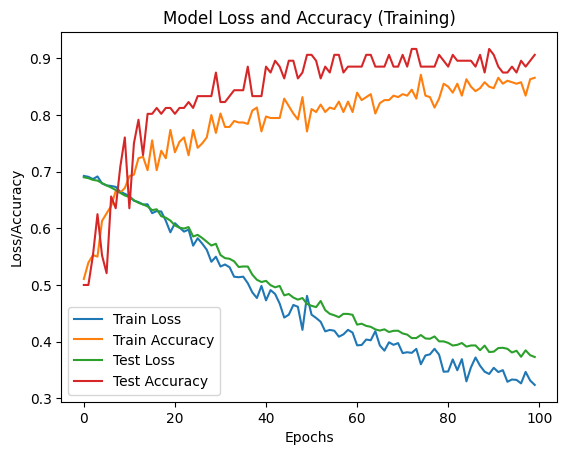

In [179]:
#Plotting the training results
import matplotlib.pyplot as plt
plt.plot(dnn_results.history["loss"])
plt.plot(dnn_results.history["accuracy"])
plt.plot(dnn_results.history["val_loss"])
plt.plot(dnn_results.history["val_accuracy"])
plt.title("Model Loss and Accuracy (Training)")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(["Train Loss", "Train Accuracy", "Test Loss", "Test Accuracy"])
plt.show()

In [182]:
y_test_pred_dnn = dnn_model.predict(x_test)

3/3 [==============================] - 0s 5ms/step


2023-05-21 19:28:39.070876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [198]:
cm = confusion_matrix(y_test.numpy().flatten().tolist(), np.where(y_test_pred_dnn >= 0.5, 1.0, 0.0).flatten().tolist())
acc = accuracy_score(y_test.numpy().flatten().tolist(), np.where(y_test_pred_dnn >= 0.5, 1.0, 0.0).flatten().tolist())

In [204]:
print("Confusion Matrix : ")
print(cm)
print()
print("Accuracy : ")
print(acc)

Confusion Matrix : 
[[46  2]
 [ 7 41]]

Accuracy : 
0.90625


In [205]:
classy_rep = classification_report(y_test.numpy().flatten().tolist(), np.where(y_test_pred_dnn >= 0.5, 1.0, 0.0).flatten().tolist())
print(classy_rep)

              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91        48
         1.0       0.95      0.85      0.90        48

    accuracy                           0.91        96
   macro avg       0.91      0.91      0.91        96
weighted avg       0.91      0.91      0.91        96



Precision: The precision for class CTL (0.87) and class AD (0.95) indicates that the classifier has a high ability to correctly identify instances of each class. A higher precision value suggests a low false positive rate.

Recall: The recall for class CTL (0.96) and class AD (0.85) indicates that the classifier is able to capture a high percentage of true positives for each class. A higher recall value suggests a low false negative rate.

F1-Score: The F1-score combines precision and recall into a single metric. Both class CTL (0.91) and class AD (0.90) have high F1-scores, which suggests a good balance between precision and recall.

Accuracy: The overall accuracy of 0.91 indicates that the classifier correctly predicts the class labels for approximately 91% of the instances.

Macro Avg and Weighted Avg: Both the macro average and weighted average F1-scores are 0.91, indicating consistent performance across classes. The weighted average considers the class imbalance, giving higher weight to the class with more instances (if any).

Overall, based on these evaluation metrics, the classifier appears to be performing well with high precision, recall, and F1-score for both classes. 

#### 1-D CNN

In [17]:
#Label encoding
def LabelEncoding(Y): 
    le = preprocessing.LabelEncoder()
    le.fit(Y)
    Y = le.transform(Y)
    return Y

y_test = LabelEncoding(y_test)
y_train = LabelEncoding(y_train)

y_test = tf.one_hot(y_test, depth=2)
y_train = tf.one_hot(y_train, depth=2)

In [5]:
cnn_model = tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=3, activation='relu', input_shape=(1258, 1)))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Conv1D(filters=3, kernel_size=3, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Conv1D(filters=3, kernel_size=3, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(4, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(2, activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1256, 4)           16        
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 628, 4)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 626, 3)            39        
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 313, 3)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 311, 3)            30        
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 155, 3)          

In [ ]:
cnn_results = cnn_model.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_test, y_test))

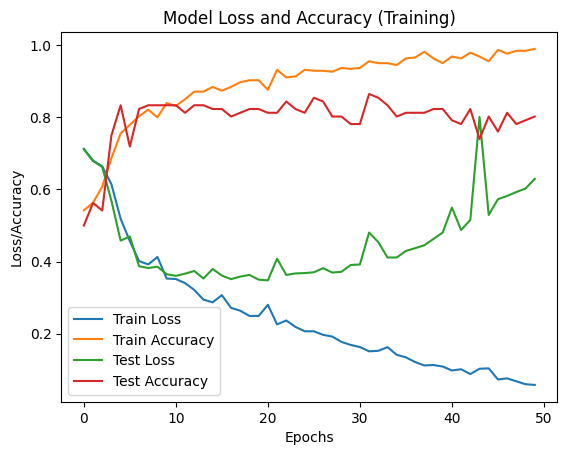

In [25]:
#Plotting the training results
import matplotlib.pyplot as plt
plt.plot(cnn_results.history["loss"])
plt.plot(cnn_results.history["accuracy"])
plt.plot(cnn_results.history["val_loss"])
plt.plot(cnn_results.history["val_accuracy"])
plt.title("Model Loss and Accuracy (Training)")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(["Train Loss", "Train Accuracy", "Test Loss", "Test Accuracy"])
plt.show()